In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def result_to_df(data, method=None, crop_size=None):
    rows = []
    method = method or data['method'][0] 
    crop_size = crop_size or str(data['crop_size'][0])
    resuts = data['results'][method][crop_size]
    for std, t in resuts.items():
        test = [t[i][0] for i in range(len(t))]
        train = [t[i][2] for i in range(len(t))]
        val = [t[i][1] for i in range(len(t))]
        
        rows.append({'Method': method,
                    'Cropsize': crop_size,
                    'Std': std,
                    'test_mean': np.mean(test),
                    'train_mean': np.mean(train), 
                    'val_mean': np.mean(val), 
                    'test_cer': np.std(test, ddof=1),
                    'train_cer': np.std(train, ddof=1), 
                    'val_cer': np.std(val, ddof=1),
                    })

    # Create DataFrame
    df1 = pd.DataFrame(rows)
    #df['mean'] = df[['t1','t2','t3','t4']].mean(axis=1)
    #df['certainty bound'] = df[['t1','t2','t3']].std(axis=1)
    df1.head(2)
    return df1

# Results Prototype hidden_dim = 256

In [3]:
without_pretrain = {"results": {"Without_pretraining": {"0.4": {"0.001": [[0.3684, 0.3553, 0.3468], [0.3681, 0.3563, 0.3473], [0.3675, 0.3543, 0.348025], [0.3676, 0.3568, 0.34995], [0.3716, 0.3637, 0.360175]]}}}, "epoch": 0, "num_classes_workers": 3, "hidden_dim": 256, "batch_size": 512}
random_croping = {"results": {"Random_crop_pytorch": {"20": {"0.001": [[0.5966, 0.5991, 0.643325], [0.5972, 0.602, 0.6454], [0.5879, 0.5915, 0.6436], [0.5886, 0.5978, 0.639625], [0.5934, 0.595, 0.643425]]}, "24": {"0.001": [[0.5516, 0.5643, 0.617175], [0.5461, 0.5594, 0.61185], [0.545, 0.5619, 0.60785], [0.5448, 0.5606, 0.61045], [0.5443, 0.5556, 0.6161]]}, "28": {"0.001": [[0.496, 0.4985, 0.547125], [0.4948, 0.4971, 0.549225], [0.5013, 0.5014, 0.5512], [0.4948, 0.497, 0.548325], [0.4944, 0.4923, 0.541175]]}}}, "epoch": 150, "num_classes_workers": 3, "hidden_dim": 256, "batch_size": 512}

In [4]:
without_pretrain_df = result_to_df(without_pretrain, method='Without_pretraining', crop_size='0.4')
without_pretrain_df.head()

,Method,Cropsize,Std,test_mean,train_mean,val_mean,test_cer,train_cer,val_cer
0,Without_pretraining,0.4,0.001,0.36864,0.35045,0.35728,0.001695,0.005567,0.003715


In [5]:
random_croping_df = result_to_df(random_croping, method='Random_crop_pytorch', crop_size='20')
random_croping_df = pd.concat([random_croping_df,result_to_df(random_croping, method='Random_crop_pytorch', crop_size='24')])
random_croping_df = pd.concat([random_croping_df,result_to_df(random_croping, method='Random_crop_pytorch', crop_size='28')])
random_croping_df.index = random_croping_df['Cropsize']
random_croping_df.head()

,Method,Cropsize,Std,test_mean,train_mean,val_mean,test_cer,train_cer,val_cer
Cropsize,,,,,,,,,
20,Random_crop_pytorch,20,0.001,0.59274,0.643075,0.59708,0.004353,0.002108,0.004008
24,Random_crop_pytorch,24,0.001,0.54636,0.612685,0.56036,0.003002,0.003902,0.003222
28,Random_crop_pytorch,28,0.001,0.49626,0.547410,0.49726,0.002881,0.003790,0.003293


In [6]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)
        
def merge_dicts(dicts):
    out = {}
    for d in dicts:
        out.update(d)
    return out
        

In [7]:
def visualize(data):
    rows = []
    method = data['method'][0]
    crop_size = str(data['crop_size'][0])
    resuts = data['results'][method][crop_size]
    for std, t in resuts.items():
        test = [t[i][0] for i in range(len(t))]
        train = [t[i][2] for i in range(len(t))]
        val = [t[i][1] for i in range(len(t))]
        
        rows.append({'Method': data['method'],
                    'Cropsize': crop_size,
                    'Std': std,
                    'test_mean': np.mean(test),
                    'train_mean': np.mean(train), 
                    'val_mean': np.mean(val), 
                    'test_cer': np.std(test, ddof=1),
                    'train_cer': np.std(train, ddof=1), 
                    'val_cer': np.std(val, ddof=1),
                    })

    # Create DataFrame
    df1 = pd.DataFrame(rows)
    #df['mean'] = df[['t1','t2','t3','t4']].mean(axis=1)
    #df['certainty bound'] = df[['t1','t2','t3']].std(axis=1)
    df1.head(2)

    act_crop_sizes = {'0.4':39.1, '0.6': 56.2, '0.8':76.6}
    fig = plt.figure(figsize=(6, 4))
    
    accuracy = df1['test_cer'].max()
    plt.plot(df1['Std'], df1['test_mean'], c='red', alpha=1, label=method.upper(), )
    plt.fill_between(df1['Std'], df1['test_mean'] - df1['test_cer'],
                    df1['test_mean'] + df1['test_cer'], color='blue', alpha=0.3, label=f'+/- {accuracy:.2%}')
    import matplotlib.ticker as mtick
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.ylim(0.3, 0.7)
    plt.title(f'{method.upper()} with Crop Size {act_crop_sizes[crop_size]:}%')
    plt.ylabel('Mean Test accuracy')
    fig.gca().set_xlabel(r"$\alpha$ (Varinace Scaling Parameter)")
    plt.grid()
    obj = plt.legend()
    tikzplotlib_fix_ncols(obj)
    import tikzplotlib
    tikzplotlib.save(f'figures/cropsize_{crop_size}_figure.tex')  # Save figure with a unique name and ".tex" extension
    return (fig , df1)

In [8]:
gccr_results1 = {"results": {"gccr": {"0.4": {"0.001": [[0.4967, 0.4741, 0.514425], [0.5013, 0.4766, 0.51615], [0.491, 0.4741, 0.5156], [0.4951, 0.471, 0.515125]], "0.01": [[0.5044, 0.4933, 0.528825], [0.5036, 0.4893, 0.530375], [0.5056, 0.4874, 0.5297], [0.4993, 0.4902, 0.52605]], "0.1": [[0.5454, 0.5465, 0.6016], [0.5423, 0.5423, 0.598075], [0.5419, 0.5297, 0.597925], [0.543, 0.5413, 0.597525]], "0.5": [[0.5915, 0.5951, 0.637875], [0.5897, 0.5898, 0.64065], [0.5894, 0.5944, 0.64365], [0.5891, 0.5938, 0.641325]], "1.0": [[0.5987, 0.5987, 0.64845], [0.5959, 0.6035, 0.6475], [0.6035, 0.6065, 0.650175], [0.6056, 0.6039, 0.654075]], "1.5": [[0.6084, 0.6137, 0.6557], [0.5987, 0.6047, 0.650325], [0.6078, 0.6066, 0.651525], [0.6057, 0.6097, 0.652325]], "2.0": [[0.6091, 0.6072, 0.65485], [0.6048, 0.6034, 0.651275], [0.6061, 0.6086, 0.648075], [0.6032, 0.6087, 0.652025]], "3.0": [[0.6007, 0.6061, 0.644475], [0.6027, 0.6055, 0.650425], [0.6061, 0.6135, 0.6499], [0.6094, 0.6137, 0.6508]], "5.0": [[0.609, 0.6103, 0.651525], [0.6066, 0.6095, 0.6532], [0.6101, 0.6091, 0.649075], [0.6069, 0.6108, 0.648175]], "100.0": [[0.5988, 0.599, 0.630575], [0.5948, 0.5997, 0.628725], [0.5953, 0.5944, 0.6234], [0.5965, 0.5991, 0.6297]], "200.0": [[0.5871, 0.5904, 0.6219], [0.5843, 0.5901, 0.61435], [0.5842, 0.5863, 0.6158], [0.5865, 0.5884, 0.621425]]}}}, "epoch": 150, "num_classes_workers": 4, "hidden_dim": 256, "batch_size": 512, "clf_epochs": 100, "Job_id": "162225", "method": ["gccr"], "crop_size": [0.4], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 100.0, 200.0], "num_of_trials": 4}
gccr_results2 = {"results": {"gccr": {"0.6": {"0.001": [[0.4924, 0.4796, 0.51245], [0.4938, 0.4883, 0.516875], [0.4949, 0.4857, 0.513525], [0.4938, 0.4818, 0.511875]], "0.01": [[0.493, 0.4804, 0.521825], [0.49, 0.4828, 0.52275], [0.4927, 0.4805, 0.5225], [0.4867, 0.4791, 0.5211]], "0.1": [[0.5235, 0.5364, 0.58545], [0.5313, 0.5445, 0.5937], [0.5289, 0.5435, 0.593175], [0.529, 0.5448, 0.59025]], "0.5": [[0.5552, 0.5702, 0.623225], [0.5536, 0.5677, 0.61895], [0.5534, 0.5681, 0.615475], [0.5567, 0.5697, 0.6196]], "1.0": [[0.5714, 0.5847, 0.6273], [0.5621, 0.5852, 0.630225], [0.5655, 0.5817, 0.628375], [0.5676, 0.582, 0.629725]], "1.5": [[0.5695, 0.5802, 0.636025], [0.5678, 0.5789, 0.627525], [0.5724, 0.5827, 0.6359], [0.5729, 0.5793, 0.6273]], "2.0": [[0.5725, 0.5787, 0.6298], [0.5683, 0.583, 0.629125], [0.5676, 0.5794, 0.63025], [0.5724, 0.5854, 0.628575]], "3.0": [[0.5786, 0.5904, 0.63265], [0.575, 0.5889, 0.628275], [0.5778, 0.5902, 0.630975], [0.5694, 0.5837, 0.63065]], "5.0": [[0.5762, 0.5886, 0.6318], [0.5793, 0.5899, 0.6342], [0.5684, 0.5901, 0.63295], [0.5739, 0.5903, 0.62975]], "100.0": [[0.5726, 0.5858, 0.624275], [0.5767, 0.5816, 0.6242], [0.5682, 0.5889, 0.626825], [0.5761, 0.5882, 0.622225]], "200.0": [[0.5711, 0.5855, 0.619025], [0.5739, 0.5877, 0.62205], [0.5712, 0.5835, 0.6174], [0.5706, 0.5814, 0.62025]]}}}, "epoch": 150, "num_classes_workers": 4, "hidden_dim": 256, "batch_size": 512, "clf_epochs": 100, "Job_id": "162223", "method": ["gccr"], "crop_size": [0.6], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 100.0, 200.0], "num_of_trials": 4}
gccr_results3 = {"results": {"gccr": {"0.8": {"0.001": [[0.4763, 0.4602, 0.50065], [0.475, 0.4571, 0.497975], [0.4755, 0.4512, 0.491675], [0.477, 0.4572, 0.4924]], "0.01": [[0.4825, 0.461, 0.5064], [0.4823, 0.4644, 0.50585], [0.4797, 0.466, 0.50365], [0.4787, 0.4617, 0.50535]], "0.1": [[0.4893, 0.4922, 0.536875], [0.4938, 0.4895, 0.535775], [0.4942, 0.4935, 0.5353], [0.4938, 0.4958, 0.537325]], "0.5": [[0.5004, 0.5061, 0.556525], [0.5061, 0.5105, 0.563725], [0.5053, 0.5127, 0.5611], [0.5061, 0.5115, 0.562575]], "1.0": [[0.4976, 0.5059, 0.561975], [0.4998, 0.5074, 0.565275], [0.5006, 0.5136, 0.561475], [0.5031, 0.5134, 0.56395]], "1.5": [[0.4952, 0.5143, 0.56175], [0.5028, 0.5116, 0.563775], [0.5034, 0.5151, 0.562675], [0.5137, 0.5152, 0.565125]], "2.0": [[0.5065, 0.5197, 0.570875], [0.5075, 0.5177, 0.5693], [0.5129, 0.5222, 0.571075], [0.5061, 0.5216, 0.570225]], "3.0": [[0.5058, 0.5156, 0.5717], [0.5028, 0.5142, 0.5717], [0.5126, 0.5187, 0.56675], [0.5123, 0.5184, 0.56405]], "5.0": [[0.5039, 0.5184, 0.562075], [0.5006, 0.5154, 0.5643], [0.5044, 0.5154, 0.56695], [0.5046, 0.5086, 0.56585]], "100.0": [[0.5088, 0.5266, 0.572075], [0.5098, 0.5243, 0.572375], [0.5141, 0.5289, 0.574125], [0.505, 0.5233, 0.57055]], "200.0": [[0.508, 0.5201, 0.572875], [0.5107, 0.5219, 0.57375], [0.5052, 0.5169, 0.56665], [0.5129, 0.5248, 0.57615]]}}}, "epoch": 150, "num_classes_workers": 4, "hidden_dim": 256, "batch_size": 512, "clf_epochs": 100, "Job_id": "162227", "method": ["gccr"], "crop_size": [0.8], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 100.0, 200.0], "num_of_trials": 4}

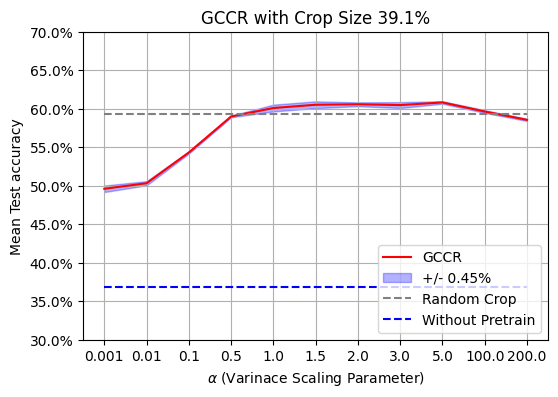

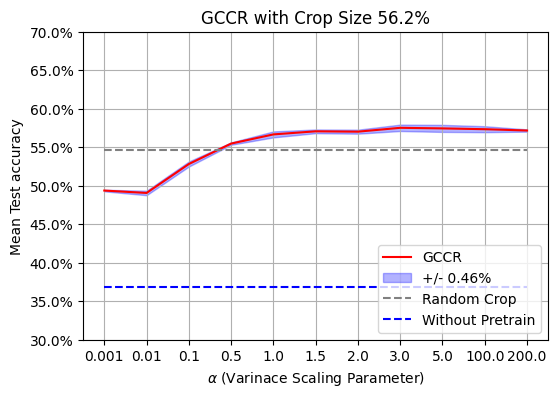

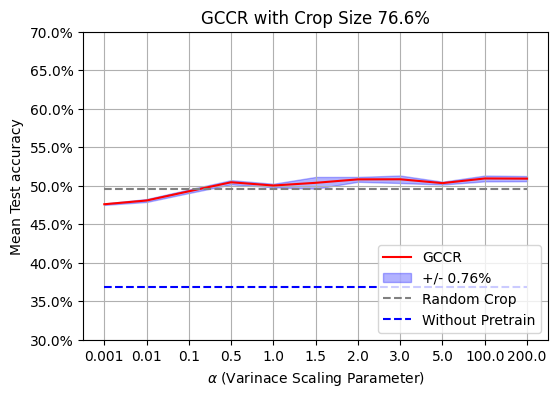

In [13]:
fig, df = visualize(gccr_results1)
x = df['Std']
y1 = np.repeat(random_croping_df.loc['20']['test_mean'], len(x))
plt.plot(x, y1, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

fig, df = visualize(gccr_results2)
x = df['Std']
y = np.repeat(random_croping_df.loc['24']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

fig, df = visualize(gccr_results3)
x = df['Std']
y = np.repeat(random_croping_df.loc['28']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

In [10]:
gcc_results1 = {"results": {"gcc": {"0.4": {"0.001": [[0.4937, 0.4798, 0.512975], [0.4938, 0.4768, 0.51005], [0.4937, 0.4824, 0.51465], [0.4883, 0.4775, 0.511975]], "0.01": [[0.4943, 0.4938, 0.523025], [0.4917, 0.4878, 0.52655], [0.4913, 0.4878, 0.5229], [0.4941, 0.4844, 0.520275]], "0.1": [[0.5552, 0.5658, 0.61055], [0.5549, 0.5659, 0.606325], [0.554, 0.5657, 0.60745], [0.5576, 0.5776, 0.616]], "0.5": [[0.6021, 0.5962, 0.63885], [0.6001, 0.5839, 0.6321], [0.6052, 0.598, 0.64], [0.6007, 0.5966, 0.638025]], "1.0": [[0.6064, 0.6043, 0.637475], [0.6155, 0.605, 0.640225], [0.6073, 0.6051, 0.6398], [0.6075, 0.5994, 0.6359]], "1.5": [[0.6154, 0.6068, 0.643], [0.614, 0.6086, 0.6421], [0.6132, 0.6046, 0.6401], [0.6136, 0.6081, 0.638275]], "2.0": [[0.6199, 0.6102, 0.644075], [0.6171, 0.6055, 0.640675], [0.6171, 0.6078, 0.641525], [0.6153, 0.6164, 0.642125]], "3.0": [[0.6214, 0.6062, 0.636925], [0.6181, 0.603, 0.634875], [0.6138, 0.6038, 0.633975], [0.6186, 0.613, 0.637825]], "5.0": [[0.6038, 0.5948, 0.6179], [0.6143, 0.5979, 0.622775], [0.6113, 0.6011, 0.62745], [0.6111, 0.5943, 0.621025]], "100.0": [[0.4288, 0.4187, 0.4248], [0.4288, 0.4292, 0.429], [0.4302, 0.4184, 0.42515], [0.4306, 0.4302, 0.430975]], "200.0": [[0.4273, 0.4238, 0.41875], [0.4197, 0.4165, 0.414175], [0.4179, 0.4146, 0.414025], [0.4249, 0.4194, 0.417625]]}}}, "epoch": 150, "num_classes_workers": 4, "hidden_dim": 256, "batch_size": 512, "clf_epochs": 100, "Job_id": "162224", "method": ["gcc"], "crop_size": [0.4], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 100.0, 200.0], "num_of_trials": 4}
gcc_results2 = {"results": {"gcc": {"0.6": {"0.001": [[0.495, 0.4737, 0.516425], [0.49, 0.4725, 0.5126], [0.4918, 0.4709, 0.51135], [0.493, 0.4693, 0.51175]], "0.01": [[0.4978, 0.4817, 0.5319], [0.4989, 0.4835, 0.528175], [0.5024, 0.4816, 0.5279], [0.5047, 0.4888, 0.5324]], "0.1": [[0.5343, 0.5337, 0.585875], [0.5299, 0.5301, 0.593225], [0.539, 0.5417, 0.592225], [0.5317, 0.5352, 0.593225]], "0.5": [[0.5737, 0.5697, 0.6232], [0.5766, 0.5757, 0.628425], [0.5768, 0.572, 0.6267], [0.5775, 0.566, 0.62485]], "1.0": [[0.5948, 0.58, 0.63335], [0.5905, 0.5811, 0.631325], [0.5929, 0.5856, 0.63465], [0.5941, 0.5802, 0.6365]], "1.5": [[0.6031, 0.5863, 0.640725], [0.603, 0.584, 0.6358], [0.6084, 0.5859, 0.640125], [0.6057, 0.5861, 0.636525]], "2.0": [[0.6062, 0.5917, 0.6338], [0.6111, 0.5861, 0.63605], [0.6033, 0.5896, 0.634475], [0.6048, 0.5947, 0.634275]], "3.0": [[0.6056, 0.5862, 0.628925], [0.6063, 0.5856, 0.629825], [0.6075, 0.5787, 0.6253], [0.6087, 0.59, 0.630675]], "5.0": [[0.6031, 0.5845, 0.62045], [0.6065, 0.5824, 0.62265], [0.605, 0.5825, 0.6186], [0.6006, 0.5767, 0.614825]], "100.0": [[0.4262, 0.4119, 0.425725], [0.4277, 0.4183, 0.42655], [0.4192, 0.4179, 0.430575], [0.4308, 0.4147, 0.434175]], "200.0": [[0.4052, 0.3924, 0.402475], [0.4087, 0.3944, 0.409125], [0.4001, 0.3889, 0.4051], [0.4138, 0.4035, 0.41205]]}}}, "epoch": 150, "num_classes_workers": 4, "hidden_dim": 256, "batch_size": 512, "clf_epochs": 100, "Job_id": "162222", "method": ["gcc"], "crop_size": [0.6], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 100.0, 200.0], "num_of_trials": 4}
gcc_results3 = {"results": {"gcc": {"0.8": {"0.001": [[0.4709, 0.4606, 0.504175], [0.473, 0.4607, 0.5021], [0.4727, 0.4605, 0.501525], [0.4808, 0.4701, 0.501]], "0.01": [[0.481, 0.4738, 0.50965], [0.485, 0.4681, 0.509425], [0.4855, 0.468, 0.5072], [0.4842, 0.4674, 0.511375]], "0.1": [[0.5061, 0.4951, 0.55145], [0.5128, 0.498, 0.547275], [0.5099, 0.4945, 0.5515], [0.509, 0.4985, 0.5488]], "0.5": [[0.5361, 0.5225, 0.578225], [0.535, 0.5307, 0.5744], [0.5406, 0.5226, 0.58215], [0.537, 0.5259, 0.5812]], "1.0": [[0.5545, 0.534, 0.590925], [0.5499, 0.533, 0.588075], [0.547, 0.5354, 0.58595], [0.547, 0.5379, 0.589075]], "1.5": [[0.5622, 0.5448, 0.589725], [0.56, 0.5389, 0.5929], [0.5608, 0.5372, 0.5877], [0.5607, 0.542, 0.588]], "2.0": [[0.5627, 0.5521, 0.58925], [0.57, 0.5507, 0.595125], [0.5591, 0.5471, 0.59425], [0.5636, 0.5491, 0.5963]], "3.0": [[0.5661, 0.5466, 0.592875], [0.5652, 0.552, 0.5886], [0.5623, 0.5465, 0.590675], [0.5687, 0.5494, 0.58565]], "5.0": [[0.5642, 0.5508, 0.58265], [0.5518, 0.5471, 0.580025], [0.5588, 0.547, 0.57875], [0.5582, 0.5497, 0.582]], "100.0": [[0.4299, 0.4277, 0.442075], [0.4316, 0.4229, 0.43915], [0.4314, 0.43, 0.4408], [0.4285, 0.4287, 0.437225]], "200.0": [[0.4125, 0.4006, 0.41385], [0.4208, 0.4057, 0.4174], [0.4243, 0.4052, 0.422475], [0.4214, 0.4029, 0.418175]]}}}, "epoch": 150, "num_classes_workers": 4, "hidden_dim": 256, "batch_size": 512, "clf_epochs": 100, "Job_id": "162226", "method": ["gcc"], "crop_size": [0.8], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 100.0, 200.0], "num_of_trials": 4}

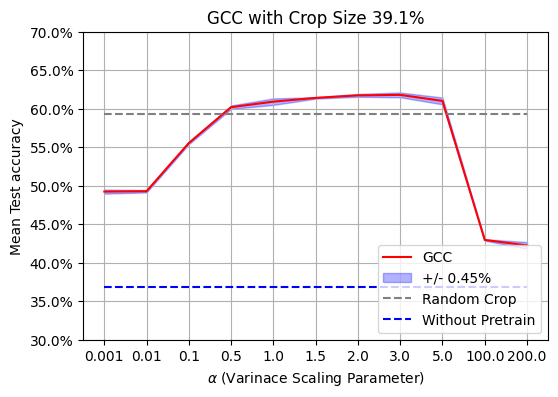

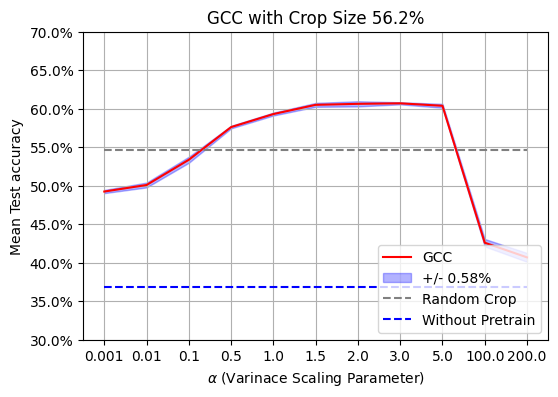

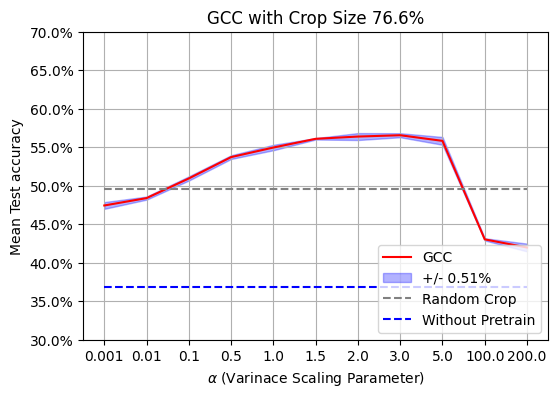

In [14]:
fig, df = visualize(gcc_results1)
x = df['Std']
y = np.repeat(random_croping_df.loc['20']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

fig, df = visualize(gcc_results2)
x = df['Std']
y = np.repeat(random_croping_df.loc['24']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()
fig, df = visualize(gcc_results3)
x = df['Std']
y = np.repeat(random_croping_df.loc['28']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()